In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, Polygon

# Load Data and Filter down to Study area parcels

In [2]:
bk_prices = pd.read_csv('data/brooklyn_prices.csv', index_col=0)
bk_prices = bk_prices[bk_prices['BOROUGH'] == 3] # make sure it's only BK

In [3]:
pluto = gpd.read_file('data/pluto.geojson')

In [4]:
addr = "373 VAN BRUNT STREET"
addr_pluto = pluto[pluto['address'] == addr]

addr_pluto_geometry = addr_pluto['geometry']

addr_coors = [float(addr_pluto_geometry.centroid.y), float(addr_pluto_geometry.centroid.x)]
addr_point =  Point(addr_coors)
print(type(addr_coors[0]))

<class 'float'>


In [5]:
# get study area pluto data
radius = 0.3 # miles
study_area = addr_point.buffer(radius / 69)
study_area_polygon = Polygon(study_area.exterior.coords)

def centroid_to_coor(centroid):
    return Point(centroid.y, centroid.x)

study_area_pluto = pluto[pluto.apply(lambda x: study_area_polygon.contains(centroid_to_coor(x['geometry'].centroid)), axis=1)]
len(study_area_pluto)

646

# Join Rolling Data and Pluto

In [6]:
def format_bbl(parcel):
    borough = str(parcel['BOROUGH'])
    block = str(parcel['BLOCK'])
    lot = str(parcel['LOT'])
    return int(borough + block.zfill(5) + lot.zfill(4))

In [7]:
# Create bbls
bk_prices['BBL'] = bk_prices.apply(format_bbl, axis=1)


In [8]:
study_area_prices = bk_prices[bk_prices.apply(lambda parcel: parcel['BBL'] in study_area_pluto['bbl'].values, axis=1)]

In [9]:
sold_parcels = study_area_pluto[study_area_pluto.apply(lambda parcel: parcel['bbl'] in study_area_prices['BBL'].values, axis=1)]

# Analyze the study area sales

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

# how many parcels were sold multiple times
# what are the transactions
# plot average sales / sq ft price of red hook vs bk

In [11]:
def prep_sales_data(df):
    df = df[df['SALE PRICE'] != 0]
    print(len(df))
    df = df[df['GROSS SQUARE FEET'] != 0]
    print(len(df))
    df['PRICE PER FT'] = df['SALE PRICE'] / df['GROSS SQUARE FEET']
    df = df.sort_values(by='SALE DATE')
    
    df = df[(np.abs(stats.zscore(df['PRICE PER FT'])) < 2.5)]
    
    df = df.set_index('SALE DATE')
    df.index = pd.to_datetime(df.index , format='%Y-%m-%d', errors='ignore')
    
    return df

In [12]:
# A lot of sales either are 0 $ or don't list the sq footage
prepped_study_area_sales = prep_sales_data(study_area_prices)
prepped_bk_sales = prep_sales_data(bk_prices)

197
156
131627
74728


In [13]:
bk_monthly_means = prepped_bk_sales.resample('M').mean()
study_area_monthly_means = prepped_study_area_sales.resample('M').mean()

## Do prices differ between commercial and residential buildings within the study area?

In [24]:
list(prepped_study_area_sales)

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BLOCK',
 'LOT',
 'EASE-MENT',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'APARTMENT NUMBER',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'TAX CLASS AT TIME OF SALE',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE PRICE',
 'BBL',
 'PRICE PER FT']

In [26]:
set(prepped_study_area_sales['BUILDING CLASS CATEGORY'])

{'01  ONE FAMILY DWELLINGS                    ',
 '01  ONE FAMILY HOMES                        ',
 '02  TWO FAMILY DWELLINGS                    ',
 '02  TWO FAMILY HOMES                        ',
 '03  THREE FAMILY DWELLINGS                  ',
 '03  THREE FAMILY HOMES                      ',
 '07  RENTALS - WALKUP APARTMENTS             ',
 '14  RENTALS - 4-10 UNIT                     ',
 '21  OFFICE BUILDINGS                        ',
 '22  STORE BUILDINGS                         ',
 '23  LOFT BUILDINGS                          ',
 '27  FACTORIES                               ',
 '29  COMMERCIAL GARAGES                      ',
 '30  WAREHOUSES                              ',
 '31  COMMERCIAL VACANT LAND                  ',
 '32  HOSPITAL AND HEALTH FACILITIES          ',
 '35  INDOOR PUBLIC AND CULTURAL FACILITIES   ',
 '41  TAX CLASS 4 - OTHER                     '}

In [27]:
set(prepped_study_area_sales['TAX CLASS AT PRESENT'])

{'1', '2', '2A', '2B', '4'}

In [28]:
colors = {'1': 'red', '2' : 'green', '2A' : 'blue', '2B' : 'black', '4' : 'purple'}

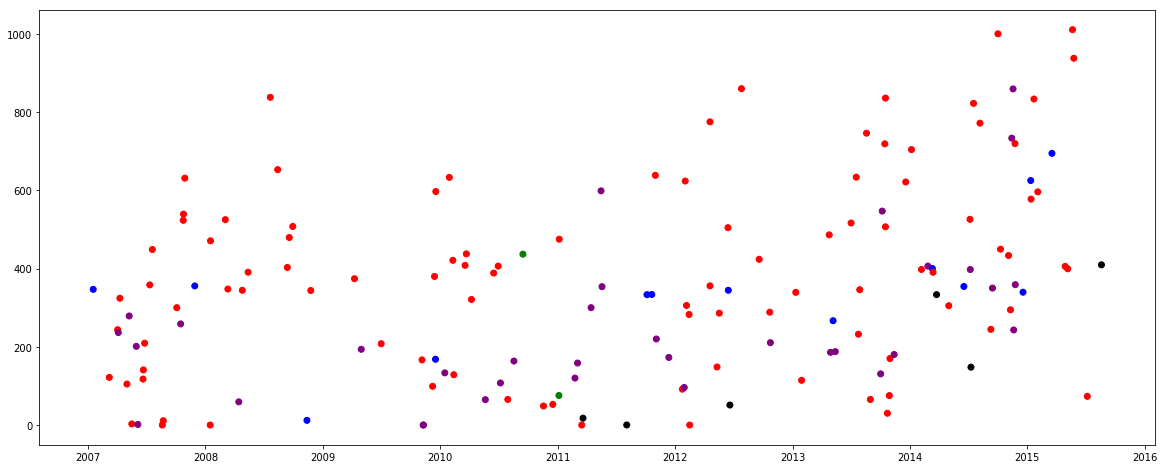

In [34]:
plt.figure(figsize=(20,8))
plt.scatter(prepped_study_area_sales.index, prepped_study_area_sales['PRICE PER FT'], c=prepped_study_area_sales['TAX CLASS AT PRESENT'].apply(lambda x: colors[x]))

In [44]:
# number of sales in each category
prepped_study_area_sales.groupby('TAX CLASS AT PRESENT').count()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BBL,PRICE PER FT
TAX CLASS AT PRESENT,,,,,,,,,,,,,,,,,,,,,
1,98,98,98,98,98,98,98,98,98,98,...,98,98,98,98,98,98,98,98,98,98
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2A,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
2B,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
4,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34


In [45]:
import statsmodels.api as sm

Float64Index([2454117.5, 2454167.5, 2454193.5, 2454195.5, 2454200.5, 2454222.5,
              2454229.5, 2454237.5, 2454251.5, 2454256.5,
              ...
              2457035.5, 2457044.5, 2457056.5, 2457100.5, 2457141.5, 2457149.5,
              2457164.5, 2457168.5, 2457210.5, 2457254.5],
             dtype='float64', name='SALE DATE', length=153)

In [49]:
y = prepped_study_area_sales['PRICE PER FT']
X = prepped_study_area_sales.index.to_julian_date()

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PRICE PER FT   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     322.6
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           2.04e-39
Time:                        12:01:20   Log-Likelihood:                -1055.5
No. Observations:                 153   AIC:                             2113.
Df Residuals:                     152   BIC:                             2116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001   7.92e-06     17.962      0.000       0.000       0.000
==============================================================================
Omnibus:                        8.341   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.837
Skew:                           0.577   Prob(JB):                       0.0121
Kurtosis:                       2.767   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Study Area compared to BK prices

In [41]:
bk_monthly_means = prepped_bk_sales.resample('4M').mean()
study_area_monthly_means = prepped_study_area_sales.resample('4M').mean()

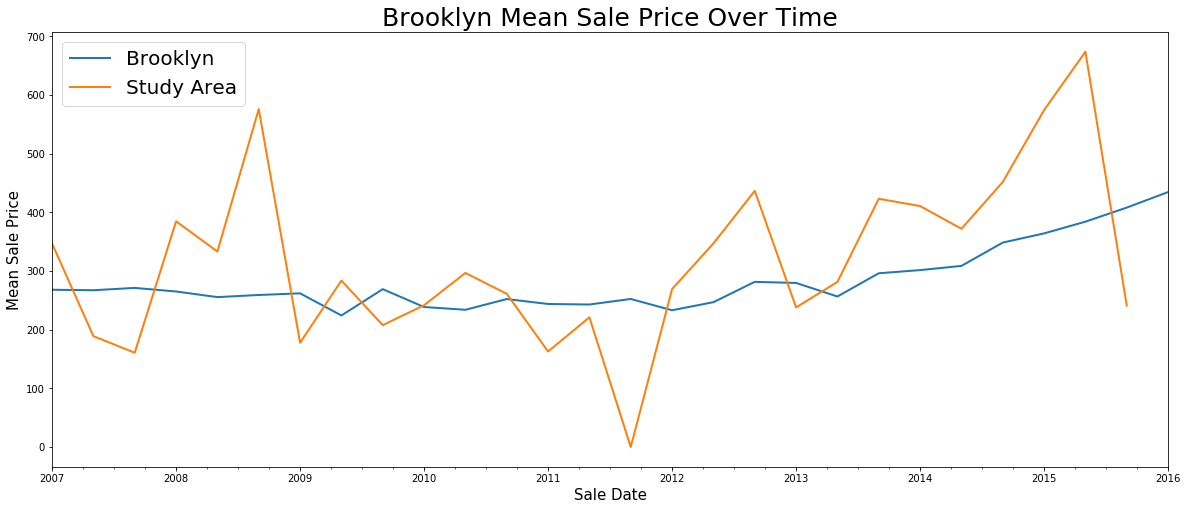

In [50]:
# Mean sale price of all buildings in Brooklyn
f, ax = plt.subplots(figsize=(20,8))
bk_monthly_means['PRICE PER FT'].plot(alpha=1,linewidth=2,ax=ax,label='Brooklyn')
study_area_monthly_means['PRICE PER FT'].plot(alpha=1,linewidth=2,ax=ax,label='Study Area')
plt.title("Brooklyn Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

# Visualize

In [15]:
import folium
import geopandas
m = folium.Map(location=addr_coors,zoom_start=14,tiles="Stamen Toner")

folium.Circle(addr_coors, radius=radius * 1609.34).add_to(m)

folium.GeoJson(
    sold_parcels['geometry'],
    name='geojson'
).add_to(m)

In [16]:
def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }

In [17]:
folium.GeoJson(
    addr_pluto_geometry,
    name='geojson',
    style_function=style_function
).add_to(m)

In [18]:
m

In [19]:
print("{} percent are 0$".format(len(study_area_prices[study_area_prices['SALE PRICE'] == 0]) / len(study_area_prices) * 100))

43.553008595988544 percent are 0$


In [20]:
fig = plt.figure(figsize=(17, 6))
plt.scatter(prepped_study_area_sales['SALE DATE'], prepped_study_area_sales['PRICE PER FT'], s=5)
plt.xticks(rotation=90)
plt

KeyError: 'SALE DATE'

<Figure size 1224x432 with 0 Axes>